## Final Project Submission

Please fill out:
* **Student name**: Zhaleh Feizollahi
* **Student pace**: self paced
* **Scheduled project review date/time**: TBD
* **Instructor name**: Eli
* **Blog post URL**: TBD


In [1]:
#import modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import pickle

In [2]:
np.random.seed(42)

In [3]:
df = pd.read_csv('kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [333]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

Upon investigating we have some columns that might be categorical: 
    - zipcode
    - waterfront

These are likely numerical or ordered:
    - view (how many times the house was viewed, NOT does it have a view)
    - year built, year renovated (age)
    - date sold
    - grade, condition
    - beds, bath, floors
    - sqft_* 
    - lat/long: see discussion in investigating features


In [334]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


### Price  / Target evaluation

There is a tail on the right, noting a positive skew for the data. And investigating those above 2 million dollars, shows that there's a lot in the 2-4 million dollar range.

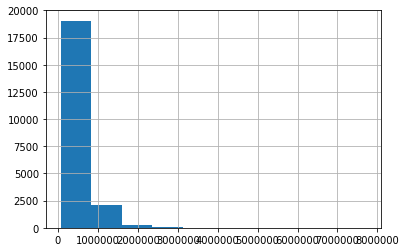

In [5]:
df.price.hist();

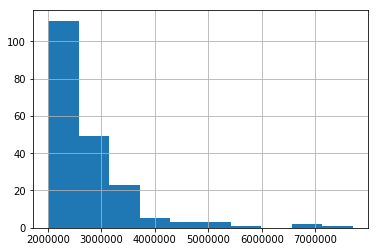

In [6]:
df[df['price'] > 2000000].price.hist();

### Missing values & Incorrect data types
**Missing Values** *Waterfront*, *year renovated*, and *view* have missing values. 


**Year renovated** A missing value for year renovated likely means never renovated. I convert this feature (below) in to "age of renovation", since a renovated place is often just like a new house. I subtract 2016 from the yr-renovated - since the dataset is from 2015. Missing values are filled with the year built so that the age of renovation is the same year as it was built. This way two values year built (same "age" conversion) and age of renovation can be useful information for price prediction.


**View** is a variable for how many times viewed. While some sales occur without viewing, it's  rare. It could also be a mistake and not correctly tracked and added to the data. The feature also seems weird to use, however it could be an indicator of desirability (quality, neighborhood) that isn't captured elswhere and competition for a particular house often drives up the price. There are just a few missing values, and dropping those rows won't change the dataset greatly. In the end, the feature is non-normal distribution and could not be transformed using log, square, square root, cubed and MinMax Scaling.


**Waterfront** has a lot of missing values ~2k\+. Waterfront property is a premium and likely to hugely affect price. I investigate the rows with missing values in the notebook "Investifating features" and fill in the values by randomly selecting 0/1 for waterfront property based on the distribution of the rest of the data.


**Date** of sale should be transformed into datetime format. 


**Sqft-basement** should be an int or float value. There are values with ?, indicating missing values. I investigated sqft_basement in the Investigating Features notebook. Similar to *view*, this feature was dropped, since even with binning with random choice the distribution could not be transformed into a normal distribution. 



In [335]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


I do some further investigation on the tails and some min max values for various features (here and in Investigating Features notebook). The most notable is the 33 bedrooms, which I determine is a mistake and drop that row.

## Fix Missing Data

There aren't that many missing view datapoints, so we could just drop them

In [336]:
df.view.isna().value_counts()

False    21534
True        63
Name: view, dtype: int64

However, we end up dropping the entire feature because of non-normal distribution and could not be transformed using log, square, square root, cubed and MinMax Scaling.

In [337]:
df.dropna(subset=['view'], inplace=True)

Need to convert date into date time format

In [338]:
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)

### Waterfront Add Missing Values w.r.t. Distribution

I could have just filled all with 0, knowing that waterfront property is very limited in Seattle. However, this set of data may some commonality that when adding the data lost their waterfront value. I investigate (in Investigate Features) the missing value data in case it tells us something about that set, i.e all waterfront or not. Most of the rows with missing waterfront values have prices very much like the non-waterfront properties, with some oultiers. There are statistical tests to determine which distribution more closely matches the unknown distribution, in replacement of eyeballing. Since this comes in later modules, I decided to use probability distribution to randomly assign a value. Since, 99% of the data has no waterfront, most random choice value will be 0. One follow up project could be to build a model that predicts waterfront/no-waterfront give the price and other features. This could be done given time constraints. 

In [339]:
prob_dist = df.waterfront.value_counts(normalize=True)
print(prob_dist)

0.0    0.992434
1.0    0.007566
Name: waterfront, dtype: float64


In [340]:
#Checked for no missing waterfront values - passed.
missing = df['waterfront'].isnull()
df.loc[missing,'waterfront'] = np.random.choice(prob_dist.index, size=len(df[missing]),p=prob_dist.values)
df[df['waterfront'].isna() == True]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


## Investigate Categorical & Ordered Features

<Figure size 1080x2160 with 0 Axes>

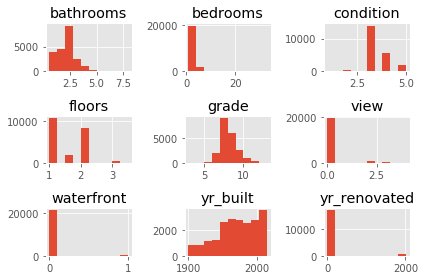

In [341]:
plt.style.use('ggplot')
plt.figure(figsize=(15, 30))
df[['bathrooms', 'bedrooms', 'floors', 'waterfront',
    'view', 'condition', 'grade', 'yr_built', 'yr_renovated']].hist()
plt.tight_layout()
plt.show();

In [342]:
df.view.describe(), df.view.value_counts()

(count    21534.000000
 mean         0.233863
 std          0.765686
 min          0.000000
 25%          0.000000
 50%          0.000000
 75%          0.000000
 max          4.000000
 Name: view, dtype: float64, 0.0    19422
 2.0      957
 3.0      508
 1.0      330
 4.0      317
 Name: view, dtype: int64)

Newest house: 2015
Oldest house: 1900


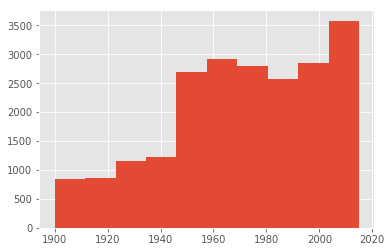

In [343]:
print("Newest house: {}".format(df['yr_built'].max()))
print("Oldest house: {}".format(df['yr_built'].min()))
df['yr_built'].hist();

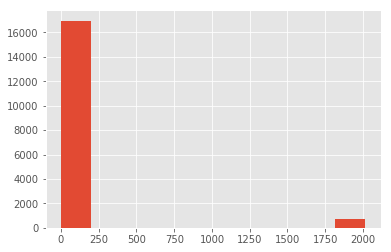

In [344]:
df['yr_renovated'].hist();

In [345]:
df['yr_renovated'] = df['yr_renovated'].fillna(0)
df['yr_renovated'] = df['yr_renovated'].astype('int64')
df.loc[df['yr_renovated'] == 0,'yr_renovated'] = df['yr_built']

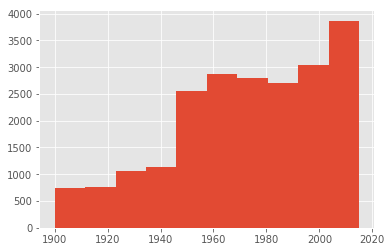

In [346]:
df['yr_renovated'].hist()

### Bedroom Investigation

In [347]:
df.bedrooms.value_counts().sort_index()

1      196
2     2754
3     9791
4     6865
5     1596
6      270
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [348]:
df[ (df['bedrooms'] > 8) & (df['price'] < 1000000)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
4092,1997200215,2014-05-07,599999.0,9,4.50,3830,6988,2.5,0.0,0.0,...,7,2450,1380.0,1938,1938,98103,47.6927,-122.338,1460,6291
4231,2902200015,2015-01-06,700000.0,9,3.00,3680,4400,2.0,0.0,0.0,...,7,2830,850.0,1908,1908,98102,47.6374,-122.324,1960,2450
8537,424049043,2014-08-11,450000.0,9,7.50,4050,6504,2.0,0.0,0.0,...,7,4050,0.0,1996,1996,98144,47.5923,-122.301,1448,3866
8748,1773100755,2014-08-21,520000.0,11,3.00,3000,4960,2.0,0.0,0.0,...,7,2400,600.0,1918,1999,98106,47.5560,-122.363,1420,4960
15147,5566100170,2014-10-29,650000.0,10,2.00,3610,11914,2.0,0.0,0.0,...,7,3010,600.0,1958,1958,98006,47.5705,-122.175,2040,11914
15856,2402100895,2014-06-25,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,...,7,1040,580.0,1947,1947,98103,47.6878,-122.331,1330,4700
18428,8823901445,2015-03-13,934000.0,9,3.00,2820,4480,2.0,0.0,0.0,...,7,1880,940.0,1918,1918,98105,47.6654,-122.307,2460,4400
19239,8812401450,2014-12-29,660000.0,10,3.00,2920,3745,2.0,0.0,0.0,...,7,1860,1060.0,1913,1913,98105,47.6635,-122.320,1810,3745


33 bedrooms in a house with 1620 sqft of living is just not possible. My 2 bedroom house is 1300 sq ft, the 4 bedroom house I grew up in is 2000 sqft. This is likely an error. I could interpret it as 3 bedrooms, but it's just one data point and will remove.

In [349]:
df = df[df['bedrooms'] != 33]

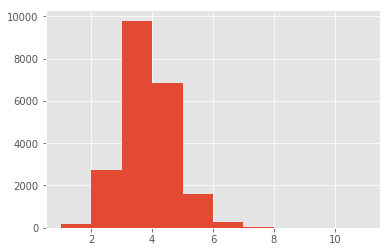

In [350]:
df['bedrooms'].hist();

### Bathroom Investigation

In [351]:
df[ df['bathrooms'] == 0.5]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2259,3971701455,2014-10-03,273000.0,2,0.5,1180,7750,1.0,0.0,0.0,...,6,590,590.0,1945,1945,98155,47.7690,-122.316,1380,8976
10413,7129800036,2015-01-14,109000.0,2,0.5,580,6900,1.0,0.0,0.0,...,5,580,0.0,1941,1941,98118,47.5135,-122.262,1570,5040
11662,7987400316,2014-08-14,255000.0,1,0.5,880,1642,1.0,0.0,0.0,...,6,500,380.0,1910,1910,98126,47.5732,-122.372,1410,2992
12029,2991000160,2014-12-12,312500.0,4,0.5,2300,5570,2.0,0.0,0.0,...,8,2300,?,1996,1996,98092,47.3285,-122.168,1820,6371


* It's weird to have 0.5 bathrooms (toilet and no shower). However, they all have low condition and grade rating. Maybe they didn't finish the house (for the house built in 1996), or the place is so old (other 3 houses built 1910-1945) it doesn't have a funcitioning shower.
* The distribution is fairly normal distribution. I won't try to transform the data, but ony scale it down to a scale of 0-1.

## Investigating Numerical Features - square footage

<Figure size 1080x2160 with 0 Axes>

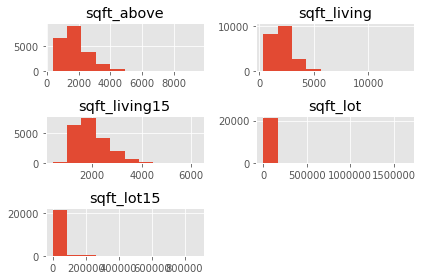

In [352]:
plt.figure(figsize=(15, 30))
df[['sqft_living','sqft_lot','sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']].hist()
plt.tight_layout()
plt.show();

In [353]:
df[['sqft_lot', 'sqft_lot15']].describe()

,sqft_lot,sqft_lot15
count,2.153300e+04,21533.000000
mean,1.509102e+04,12751.453397
std,4.138112e+04,27256.060980
min,5.200000e+02,651.000000
25%,5.040000e+03,5100.000000
50%,7.617000e+03,7620.000000
75%,1.068800e+04,10083.000000
max,1.651359e+06,871200.000000


There seems to be a tail for sqft of the lot, which is expected. Only a few places will have large plots of land. Below I select these rows to see if there's anything odd.

In [354]:
df[ df['sqft_lot'] > 200000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
145,1526069017,2014-12-03,921500.0,4,2.50,3670,315374,2.0,0.0,0.0,...,9,3670,0.0,1994,1994,98077,47.7421,-122.026,2840,87991
238,326069104,2014-07-01,800000.0,3,3.50,3830,221284,2.0,0.0,0.0,...,10,3530,300.0,1993,1993,98077,47.7641,-122.023,2920,148539
380,1726059053,2014-09-16,270000.0,2,1.50,1380,209959,1.0,0.0,0.0,...,6,1380,0.0,1954,1954,98011,47.7461,-122.195,3130,19868
443,822079033,2015-04-22,350000.0,3,1.50,1250,219978,1.0,0.0,0.0,...,6,1250,0.0,1980,1980,98038,47.4056,-121.955,1930,210394
527,3225079035,2014-06-18,1600000.0,6,5.00,6050,230652,2.0,0.0,3.0,...,11,6050,0.0,2001,2001,98024,47.6033,-121.943,4210,233971
561,1921069084,2014-07-07,404950.0,4,2.25,2340,217014,1.0,0.0,0.0,...,8,2340,0.0,1982,1982,98092,47.2953,-122.083,2340,107898
681,3526069070,2014-05-28,799000.0,4,3.00,2580,209523,2.0,0.0,0.0,...,8,2580,0.0,1984,1984,98053,47.6932,-122.006,3440,213444
762,826079094,2015-03-24,330000.0,3,2.00,1400,218252,1.0,0.0,0.0,...,7,1400,0.0,1997,1997,98019,47.7576,-121.934,2230,218222
858,623069068,2014-06-27,425000.0,3,1.00,1520,213444,1.5,0.0,3.0,...,8,1520,0.0,1988,1988,98027,47.5081,-122.093,2640,213444
928,7937600830,2014-08-08,390000.0,4,3.00,2570,262018,1.0,0.0,0.0,...,7,1420,1150.0,1988,1988,98058,47.4417,-122.090,2260,19811


In [355]:
df['sqft_lot'].max()

1651359

In [356]:
#FIND PRICE / ROW
df[ df['sqft_lot'] == df['sqft_lot'].max()]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1717,1020069017,2015-03-27,700000.0,4,1.0,1300,1651359,1.0,0.0,3.0,...,6,1300,0.0,1920,1920,98022,47.2313,-122.023,2560,425581


The maximum lot size is 1.6 million square feet, which seems huge. But a quick internet search on how big that is shows that it's possible to have a lot that is 1 million square feet. It's about 3 football fields wide and length, so 1.6 probably 4.5 football fields. 


https://www.quora.com/What-would-1-million-square-feet-look-like

The size of the house is quite small, but the zip code 98022 which is quite far from Seattle and in a rural area. So it's a reasonable datapoint.

#### Fix lat/long issues 

See investigation notebook for lat/long investigation. I determine there's a few data points have incorrect longitude.

In [357]:
fix = df.index[(df['zipcode'] == 98014) & (df['long'] > -121.7)].tolist()
df.loc[fix,'long'] = df.loc[fix].long - 0.6

### Save cleaned up data

Cleaned up data is invaluable and reusable by the community. Below saves the dataframe. 

In [358]:
pickle.dump(df, open( "all_data_cleaned.p", "wb" ) )

### Investigate Correlations & Drop Columns

In [359]:
corr = df.corr().abs().stack()
corr = corr[corr.index.get_level_values(0) != corr.index.get_level_values(1)]
corr[ corr > 0.75 ]

bathrooms      sqft_living      0.755274
sqft_living    bathrooms        0.755274
               grade            0.762395
               sqft_above       0.876554
               sqft_living15    0.756206
grade          sqft_living      0.762395
               sqft_above       0.755973
sqft_above     sqft_living      0.876554
               grade            0.755973
yr_built       yr_renovated     0.926394
yr_renovated   yr_built         0.926394
sqft_living15  sqft_living      0.756206
dtype: float64

I used two methods to remove correlations.  
- Transformation 1: remove fewest number of features (remove sqf living & sqf above)
- Transformation 2: preserve sqft living & sqft above and remove the rest

At first I decided to drop the fewest number of correlated features  so as to preserve more information. However, once we did transformations of the features many could not be normalized and ended up dropping many features that indicate size of the house (basement, bathrooms, sqft living 15). That's how I ended up trying both methods and compare models (modeling notebook).

### Adding My house

I happened to have bought a house in 2015 in King County. One fun idea I had was to try and predict the price of my house. Here I add my house into the dataset before transformations. Scaling relies on using the entire dataset (it needs min/max or mean of the dataset). So, rather than saving all the scalers and doing the transformation in the prediction notebook, I'll add my data point here and save as it as an already transformed data.

Firstly, I want to make sure my house is not alrady in the dataset. Otherwise, I might be testing on the train data - which is cheating. Fortunately, my house is not already included in the dataset. The closest one was sold 10 days before but doesn't have a basement and is a bit too small.

In [360]:
#checking if my house is here .... :)
df[ (df['zipcode'] == 98144) & (df['yr_built'] == 2009)
   & (df['bedrooms'] == 2) & (df['bathrooms'] == 1.5)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15443,567000380,2015-03-02,365000.0,2,1.5,820,1270,2.0,0.0,0.0,...,7,820,0.0,2009,2009,98144,47.5925,-122.295,1130,1201
17666,424049283,2015-04-15,345000.0,2,1.5,830,1034,2.0,0.0,0.0,...,8,830,0.0,2009,2009,98144,47.5926,-122.300,1130,2534
20257,567000381,2015-03-28,378000.0,2,1.5,980,853,2.0,0.0,0.0,...,7,820,160.0,2009,2009,98144,47.5925,-122.295,1130,1270
21361,597000593,2014-11-17,403000.0,2,1.5,1240,1101,2.0,0.0,0.0,...,8,1080,160.0,2009,2009,98144,47.5758,-122.309,1530,1209
21562,567000385,2014-06-23,362500.0,2,1.5,940,1768,2.0,0.0,0.0,...,7,940,0.0,2009,2009,98144,47.5925,-122.295,1130,1159


In [361]:
#create an id that doesn't already exist. id = 1 would work 
df['id'].max(), df['id'].min()

(9900000190, 1000102)

In [362]:
#find average lot15 size, since I'm not sure
df[(df['zipcode'] == 98144) & (df['bedrooms'] == 2)& (df['yr_built'] == 2009) ].sqft_lot15.mean()

1483.0

In [363]:
#find average living15 size, since I'm not sure
df[(df['zipcode'] == 98144) & (df['bedrooms'] == 2)& (df['yr_built'] == 2009) ].sqft_living15.mean()

1186.3636363636363

In [364]:
my_house = {'id':1,
            'zipcode':98144,
            'date': '3/12/2015',
            'bathrooms':1.5,
            'bedrooms': 2,
            'floors': 2,
            'sqft_basement': 221,
            'waterfront':0,
            'sqft_above': 1156,
            'sqft_living': 1377,
            'sqft_living15': 1186, 
            'sqft_lot': 1402, 
            'sqft_lot15': 1483, 
            'yr_renovated': 0,
            'yr_built': 2009,
            'grade': 7,
            'condition': 3,
            'lat': 47.588,
            'long': -122.304,
            'view': 0,
            'price': 390000,
}
my_house_df = pd.DataFrame(my_house, index=[0])
my_house_df.head()

,id,zipcode,date,bathrooms,bedrooms,floors,sqft_basement,waterfront,sqft_above,sqft_living,...,sqft_lot,sqft_lot15,yr_renovated,yr_built,grade,condition,lat,long,view,price
0,1,98144,3/12/2015,1.5,2,2,221,0,1156,1377,...,1402,1483,0,2009,7,3,47.588,-122.304,0,390000


In [365]:
my_house_df['date'] = pd.to_datetime(my_house_df['date'], infer_datetime_format=True)

In [366]:
#make sure we have all columsn
set(df.columns).difference(my_house_df.columns)

set()

In [367]:
set(my_house_df.columns).difference(df.columns)

set()

In [368]:
#add to data
df = df.append(my_house_df, ignore_index=True, sort=False)

In [369]:
#check if it's there
df[df['id'] == 1]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
21533,1,2015-03-12,390000.0,2,1.5,1377,1402,2.0,0.0,0.0,...,7,1156,221,2009,0,98144,47.588,-122.304,1186,1483


## Transform / Normalize / Standardize data

### Model 1: Transformations 1

In the transformatino function below, I remove the following highly correlated features by not passing them into the new dataframe.

  
<pre class="tab">
* bathrooms      --      0.755274
* grade          --      0.762395
* sqft_above     --      0.876554
* sqft_living15  --      0.756206
* yr_renovated   --      0.926394
</pre>

In the first three models I don't use **Lat/Long** features. I found the following article that said zipcode is a better proxy for location than lat/long. I did try creating lat-long bin combinations to try and mimic smaller zipcodes or neighborhoods (see investigating notebook) but it created too many categories (~400 depending on bin size) and therefore too many features after creating one-hot vectors to train on. Later, I add lat/long as numerical features with only scaling/transformation - no binning to the best model, but it does not result in a better model.


https://datascience.stackexchange.com/questions/23651/can-gps-coordinates-latitude-and-longitude-be-used-as-features-in-a-linear-mod

In [302]:
#Takes a dataframe input and parses features, transforms (if any) and scales data.
def transform_data(df):
    tr_df = pd.DataFrame()
    
    #Numerical transformations:
   
    living_scaler = StandardScaler()
    tr_df['sqft_living'] = np.log(df['sqft_living'])
    tr_df['sqft_living'] = living_scaler.fit(tr_df[['sqft_living']]).transform(tr_df[['sqft_living']])
    
    lot_scaler = StandardScaler()
    tr_df['sqft_lot'] = np.log(df['sqft_lot'])
    tr_df['sqft_lot'] = lot_scaler.fit(tr_df[['sqft_lot']]).transform(tr_df[['sqft_lot']])
    
    scaler2 = MinMaxScaler()
    tr_df['sqft_lot15'] = np.log(df['sqft_lot15'])
    tr_df['sqft_lot15'] = scaler2.fit(tr_df[['sqft_lot15']]).transform(tr_df[['sqft_lot15']])
    
    bedroom_scaler = StandardScaler()
    tr_df['bedrooms'] = bedroom_scaler.fit(df[['bedrooms']]).transform(df[['bedrooms']])

    yr_build_scaler = StandardScaler()
    tr_df['age'] = 2016 - df['yr_built']
    tr_df['age'] = np.sqrt(tr_df['age'])
    tr_df['age'] = yr_build_scaler.fit(tr_df[['age']]).transform(tr_df[['age']])
    
    yr_reno_scaler = StandardScaler()
    tr_df['reno_age'] = 2016 - df['yr_renovated']
    tr_df['reno_age'] = np.sqrt(tr_df['reno_age'])
    tr_df['reno_age'] = yr_reno_scaler.fit(tr_df[['reno_age']]).transform(tr_df[['reno_age']])
    
    #Categorical
    tr_df['waterfront'] = df.waterfront.astype('category').astype('float')
    tr_df['zipcode'] = df.zipcode.astype('category')
    tr_df = pd.get_dummies(tr_df, columns=['zipcode'], prefix=["zip"])
    
    tr_df['id'] = df['id']
    
    return tr_df

#### Non-Normal columns 
* **Floors** cannot be used since it breaks the assumption of normality. No transformations: log, sqrt, square or cube, & minmax scaling seemed to change the distribution.
* **ID** is only a random ID for tracking data points and not useful for modeling.
* **Viewed, Condition, Sqft Basement** also non-normal.

In [303]:
#transform data, then remove my house
transformed_data = transform_data(df)
my_house_tr = transformed_data[transformed_data['id'] == 1]
transformed_data = transformed_data[transformed_data['id'] != 1]

/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


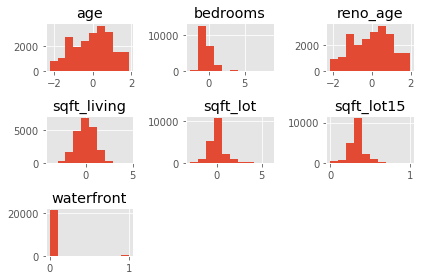

In [304]:
transformed_data[['sqft_living', 'sqft_lot', 'sqft_lot15', 
                  'bedrooms', 'age', 'reno_age', 'waterfront' ]].hist()
plt.tight_layout()

In [305]:
#find correlations again
corr = transformed_data.corr().abs().stack()
corr = corr[corr.index.get_level_values(0) != corr.index.get_level_values(1)]
corr[ corr > 0.75 ]

sqft_lot    sqft_lot15    0.918713
sqft_lot15  sqft_lot      0.918713
age         reno_age      0.927006
reno_age    age           0.927006
dtype: float64

In [306]:
#remove correlated features
transformed_data.drop(columns=['sqft_lot15', 'age', 'id'], inplace=True)
my_house_tr.drop(columns=['sqft_lot15', 'age', 'id'], inplace=True)

In [370]:
transformed_data.columns

Index(['sqft_living', 'sqft_lot', 'bedrooms', 'reno_age', 'waterfront',
       'zip_98001', 'zip_98002', 'zip_98003', 'zip_98004', 'zip_98005',
       'zip_98006', 'zip_98007', 'zip_98008', 'zip_98010', 'zip_98011',
       'zip_98014', 'zip_98019', 'zip_98022', 'zip_98023', 'zip_98024',
       'zip_98027', 'zip_98028', 'zip_98029', 'zip_98030', 'zip_98031',
       'zip_98032', 'zip_98033', 'zip_98034', 'zip_98038', 'zip_98039',
       'zip_98040', 'zip_98042', 'zip_98045', 'zip_98052', 'zip_98053',
       'zip_98055', 'zip_98056', 'zip_98058', 'zip_98059', 'zip_98065',
       'zip_98070', 'zip_98072', 'zip_98074', 'zip_98075', 'zip_98077',
       'zip_98092', 'zip_98102', 'zip_98103', 'zip_98105', 'zip_98106',
       'zip_98107', 'zip_98108', 'zip_98109', 'zip_98112', 'zip_98115',
       'zip_98116', 'zip_98117', 'zip_98118', 'zip_98119', 'zip_98122',
       'zip_98125', 'zip_98126', 'zip_98133', 'zip_98136', 'zip_98144',
       'zip_98146', 'zip_98148', 'zip_98155', 'zip_98166', 'zip_

The final dataframe for modeling should contain the following features. It has a fair amount of varied types of information, however - we have removed a lot of features. If the model doesn't work well - we might try other types of modeling that could include non-normally distributed values or other ways of transforming the data.

In [322]:
#check if transformed data has same number of rows as the target data frame: price 
len(df.price[df['id'] != 1]), len(transformed_data)

(21533, 21533)

In [307]:
#save transformed data
pickle.dump(my_house_tr, open("my_house.p", "wb" ) )

In [308]:
pickle.dump(transformed_data, open("data.p", "wb" ) )

In [324]:
pickle.dump(df.price[df['id'] != 1], open( "target.p", "wb" ) )

### Model 2: Transformations 2

Removing the following correlated features: 
- yr built
- sqf living
- sq above 

In [309]:
#Takes a dataframe input and parses features, transforms (if any) and scales data.
            
def transform_data_2(df):
    tr_df = pd.DataFrame()
    
    #Numerical transformations:
    
    living_scaler = StandardScaler()
    tr_df['sqft_living15'] = np.log(df['sqft_living15'])
    tr_df['sqft_living15'] = living_scaler.fit(tr_df[['sqft_living15']]).transform(tr_df[['sqft_living15']])
   
    lot_scaler = StandardScaler()
    tr_df['sqft_lot'] = np.log(df['sqft_lot'])
    tr_df['sqft_lot'] = lot_scaler.fit(tr_df[['sqft_lot']]).transform(tr_df[['sqft_lot']])
    
    scaler2 = MinMaxScaler()
    tr_df['sqft_lot15'] = np.log(df['sqft_lot15'])
    tr_df['sqft_lot15'] = scaler2.fit(tr_df[['sqft_lot15']]).transform(tr_df[['sqft_lot15']])
    
    #Scale & Transformation ordered data
    
    bathroom_scaler = MinMaxScaler()
    tr_df['bathrooms'] = np.log(df['bathrooms'])
    tr_df['bathrooms'] = bathroom_scaler.fit(tr_df[['bathrooms']]).transform(tr_df[['bathrooms']])
    
    #Scale numerical data
    bedroom_scaler = StandardScaler()
    tr_df['bedrooms'] = bedroom_scaler.fit(df[['bedrooms']]).transform(df[['bedrooms']])
    
    grade_scaler = StandardScaler()
    tr_df['grade'] = np.log(df['grade'])
    tr_df['grade'] = grade_scaler.fit(tr_df[['grade']]).transform(tr_df[['grade']])
    
    yr_reno_scaler = StandardScaler()
    tr_df['reno_age'] = 2016 - df['yr_renovated']
    tr_df['reno_age'] = np.sqrt(tr_df['reno_age'])
    tr_df['reno_age'] = yr_reno_scaler.fit(tr_df[['reno_age']]).transform(tr_df[['reno_age']])
    
    #Categorical
    tr_df['waterfront'] = df.waterfront.astype('category').astype('float')
    tr_df['zipcode'] = df.zipcode.astype('category')
    tr_df = pd.get_dummies(tr_df, columns=['zipcode'], prefix=["zip"])
    
    tr_df['id'] = df['id']
      
    return tr_df

In [310]:
transformed_2_data = transform_data_2(df)
my_house_tr2 = transformed_2_data[transformed_2_data['id'] == 1]
transformed_2_data = transformed_2_data[transformed_2_data['id'] != 1]

/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


In [311]:
transformed_2_data[transformed_2_data['id'] == 1]

,sqft_living15,sqft_lot,sqft_lot15,bathrooms,bedrooms,grade,reno_age,waterfront,zip_98001,zip_98002,...,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199,id


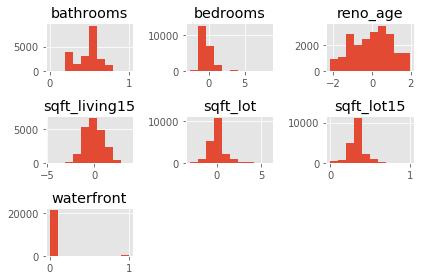

In [313]:
transformed_2_data[['sqft_lot', 'sqft_lot15', 'sqft_living15',
                  'bedrooms', 'reno_age', 'waterfront', 'bathrooms' ]].hist()
plt.tight_layout()

In [314]:
#check correlations again
corr = transformed_2_data.corr().abs().stack()
corr = corr[corr.index.get_level_values(0) != corr.index.get_level_values(1)]
corr[ corr > 0.75 ]

sqft_lot    sqft_lot15    0.918713
sqft_lot15  sqft_lot      0.918713
dtype: float64

In [318]:
#remove correlated data, id
transformed_2_data.drop(columns=['sqft_lot15', 'id'], inplace=True)
my_house_tr2.drop(columns=['sqft_lot15', 'id'], inplace=True)

In [319]:
pickle.dump(my_house_tr2, open("my_house_2.p", "wb" ) )

In [317]:
pickle.dump(transformed_2_data, open( "data_2.p", "wb" ) )

### Model 3: Transformation 2 with date info

Here I convert date of sale into different features year/month/day or combination thereof. 

In [279]:
def add_date_info(df):
    df['year'] = df['date'].map(lambda x: 0 if x.year == 2014 else 1)
    
    df['month'] = df['date'].map(lambda x: x.month)
    df['month'] = np.sqrt(df['month'])
    m_scaler = MinMaxScaler()
    df['month'] = m_scaler.fit(df[['month']]).transform(df[['month']])
    
    df['year_month'] = df['date'].map(lambda x: x.year + x.month)
    df['year_month'] = np.log(df['year_month'])
    ym_scaler = StandardScaler()
    df['year_month'] = ym_scaler.fit(df[['year_month']]).transform(df[['year_month']])
    
    df['day_since_min'] = pd.Series(df['date'] - df['date'].min()).dt.days
    #log, square, sqrt, cubed transformation does not make the dist more normal. 
    scale_days = MinMaxScaler()
    df['day_since_min'] = scale_days.fit(df[['day_since_min']]).transform(df[['day_since_min']])
    
    df.drop(columns=['date'], inplace=True)  
    
    return df

/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


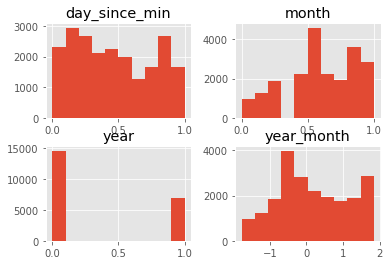

In [280]:
transformed_2_data['date'] = df['date']
tr_2_date = add_date_info(transformed_2_data)
tr_2_date[['year', 'month', 'year_month', 'day_since_min']].hist();

In [281]:
tr_2_date.columns

Index(['sqft_living15', 'sqft_lot', 'bathrooms', 'bedrooms', 'grade',
       'reno_age', 'waterfront', 'zip_98001', 'zip_98002', 'zip_98003',
       'zip_98004', 'zip_98005', 'zip_98006', 'zip_98007', 'zip_98008',
       'zip_98010', 'zip_98011', 'zip_98014', 'zip_98019', 'zip_98022',
       'zip_98023', 'zip_98024', 'zip_98027', 'zip_98028', 'zip_98029',
       'zip_98030', 'zip_98031', 'zip_98032', 'zip_98033', 'zip_98034',
       'zip_98038', 'zip_98039', 'zip_98040', 'zip_98042', 'zip_98045',
       'zip_98052', 'zip_98053', 'zip_98055', 'zip_98056', 'zip_98058',
       'zip_98059', 'zip_98065', 'zip_98070', 'zip_98072', 'zip_98074',
       'zip_98075', 'zip_98077', 'zip_98092', 'zip_98102', 'zip_98103',
       'zip_98105', 'zip_98106', 'zip_98107', 'zip_98108', 'zip_98109',
       'zip_98112', 'zip_98115', 'zip_98116', 'zip_98117', 'zip_98118',
       'zip_98119', 'zip_98122', 'zip_98125', 'zip_98126', 'zip_98133',
       'zip_98136', 'zip_98144', 'zip_98146', 'zip_98148', 'zip_98

In [282]:
#check for correlation on date columns
corr = tr_2_date.corr().abs().stack()
corr = corr[corr.index.get_level_values(0) != corr.index.get_level_values(1)]
corr[ corr > 0.75 ]

year           month            0.812820
               day_since_min    0.853450
month          year             0.812820
               year_month       0.976074
year_month     month            0.976074
day_since_min  year             0.853450
dtype: float64

In [284]:
#drop and check correlations
tr_2_date.drop(columns=['month', 'year'], inplace=True)
corr = tr_2_date.corr().abs().stack()
corr = corr[corr.index.get_level_values(0) != corr.index.get_level_values(1)]
corr[ corr > 0.75 ]

Series([], dtype: float64)

In [320]:
#do the same for my house
my_house_tr2['date'] = pd.to_datetime(df.date[df['id'] == 1] , infer_datetime_format=True)
my_house_tr2_date = add_date_info(my_house_tr2)
my_house_tr2_date.drop(columns=['month', 'year'], inplace=True)
my_house_tr2_date

/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,sqft_living15,sqft_lot,bathrooms,bedrooms,grade,reno_age,waterfront,zip_98001,zip_98002,zip_98003,...,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199,year_month,day_since_min
21533,-1.407791,-1.932643,0.396241,-1.516973,-0.525731,16.30045,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0


In [321]:
#save data
pickle.dump( my_house_tr2_date, open( "my_house_2_date.p", "wb" ) )

In [287]:
pickle.dump(tr_2_date, open( "data_2_date.p", "wb" ) )

### Model 4: Transformation 2, date and numerical lat / long

In [288]:
def lat_long_transform(df):
    lat_scaler = StandardScaler()
    df.loc[:,'lat'] = np.square(df['lat'])
    df.loc[:,'lat']= lat_scaler.fit(df[['lat']]).transform(df[['lat']])
       
    #Double scaling - seemed to be most normal distribution. 
    #(Discovered by accident through code bug)
    long_scaler = MinMaxScaler()
    df.loc[:,'long'] = np.log(df['long'] * -1 + 1)
    df.loc[:,'long'] = long_scaler.fit(df[['long']]).transform(df[['long']])
    
    long2_scaler = MinMaxScaler()
    df.loc[:,'long'] = np.square(df['long'])
    df.loc[:,'long'] = long2_scaler.fit(df[['long']]).transform(df[['long']])
    return df

/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

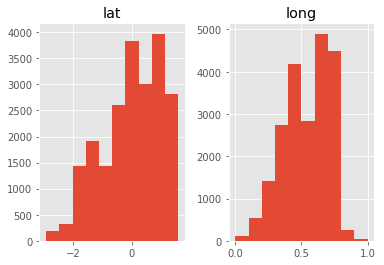

In [289]:
temp_df = lat_long_transform(df[['lat', 'long']])
temp_df[['lat', 'long']].hist();

In [290]:
temp_df = transform_data_2(df)
temp_df['date'] = df['date']
data_df_transform2_date_latlong = add_date_info(temp_df)
data_df_transform2_date_latlong['lat'] = df['lat']
data_df_transform2_date_latlong['long'] = df['long']
data_df_transform2_date_latlong = lat_long_transform(data_df_transform2_date_latlong)
data_df_transform2_date_latlong.columns

/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Index(['sqft_living15', 'sqft_lot', 'sqft_lot15', 'bathrooms', 'bedrooms',
       'grade', 'reno_age', 'waterfront', 'zip_98001', 'zip_98002',
       'zip_98003', 'zip_98004', 'zip_98005', 'zip_98006', 'zip_98007',
       'zip_98008', 'zip_98010', 'zip_98011', 'zip_98014', 'zip_98019',
       'zip_98022', 'zip_98023', 'zip_98024', 'zip_98027', 'zip_98028',
       'zip_98029', 'zip_98030', 'zip_98031', 'zip_98032', 'zip_98033',
       'zip_98034', 'zip_98038', 'zip_98039', 'zip_98040', 'zip_98042',
       'zip_98045', 'zip_98052', 'zip_98053', 'zip_98055', 'zip_98056',
       'zip_98058', 'zip_98059', 'zip_98065', 'zip_98070', 'zip_98072',
       'zip_98074', 'zip_98075', 'zip_98077', 'zip_98092', 'zip_98102',
       'zip_98103', 'zip_98105', 'zip_98106', 'zip_98107', 'zip_98108',
       'zip_98109', 'zip_98112', 'zip_98115', 'zip_98116', 'zip_98117',
       'zip_98118', 'zip_98119', 'zip_98122', 'zip_98125', 'zip_98126',
       'zip_98133', 'zip_98136', 'zip_98144', 'zip_98146', 'zip_9

In [292]:
#check transformations again
data_df_transform2_date_latlong.drop(columns=['sqft_lot15', 'month', 'year'], inplace=True)
corr = data_df_transform2_date_latlong.corr().abs().stack()
corr = corr[corr.index.get_level_values(0) != corr.index.get_level_values(1)]
corr[ corr > 0.75 ]

Series([], dtype: float64)

In [293]:
#remove house from general dataset
my_house_2_date_latlong = data_df_transform2_date_latlong[
    data_df_transform2_date_latlong['id'] == 1]
data_df_transform2_date_latlong = data_df_transform2_date_latlong[
    data_df_transform2_date_latlong['id'] != 1]

In [294]:
#check if we did remove my house
data_df_transform2_date_latlong[
    data_df_transform2_date_latlong['id'] == 1]

,sqft_living15,sqft_lot,bathrooms,bedrooms,grade,reno_age,waterfront,zip_98001,zip_98002,zip_98003,...,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199,id,year_month,day_since_min,lat,long


In [295]:
#save data
pickle.dump( my_house_2_date_latlong, open( "my_house_2_date_latlong.p", "wb" ) )

In [296]:
pickle.dump( data_df_transform2_date_latlong, open( "data_2_date_latlong.p", "wb" ) )